<a href="https://colab.research.google.com/github/ykitaguchi77/Kaggle/blob/main/RSNA_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Kaggle_spine EfficientNet baseline**

https://www.kaggle.com/code/thedevastator/tf-rsna-efficient-net-baseline

#今回の解析における問題点

骨折を判別できてもどの椎骨のものかを判定できなければ当てられない

スライスの幅が症例により異なる？

#提案手法

椎骨別に検討した方が良さそう

Semantic segmentationにより椎骨を塗り分ける

それぞれの椎骨について骨折があるかどうかの鑑別を学習させる

In [1]:
!pip install path
!pip install pydicom
import os
import cv2
import glob
import traceback
import cv2 as cv
import numpy as np
import pandas as pd
from path import Path
from tqdm import tqdm
import nibabel as nib
import pydicom as dicom
import tensorflow as tf
from keras import layers
from pydicom import dcmread
from tensorflow import keras
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from pydicom.data import get_testdata_files
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
from pydicom.pixel_data_handlers.util import apply_voi_lut
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import os
import gc
import cv2
import copy
import time
import math
import random
import string
import joblib
import tifffile
import numpy as np 
import pandas as pd 
import torch
from torch import nn
import seaborn as sns
import pydicom as dicom
from torchvision import models
from scipy.special import expit
from pydicom import dcmread
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torch.optim import lr_scheduler
import warnings
warnings.filterwarnings("ignore")

#Gdriveをマウント
from google.colab import drive
drive.mount('/content/drive')

os.chdir("/content/drive/MyDrive/Kaggle/rsna-2022-cervical-spine-fracture-detection") #親フォルダ


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 4.4 MB/s 
Mounted at /content/drive


In [2]:
bad = np.array([['1.2.826.0.1.3680043.10197_C1', '1.2.826.0.1.3680043.10197','C1'],['1.2.826.0.1.3680043.10454_C1', '1.2.826.0.1.3680043.10454','C1'],['1.2.826.0.1.3680043.10690_C1', '1.2.826.0.1.3680043.10690','C1']], dtype=np.object)

debug = False
train_df = pd.read_csv("./train.csv").head(10000)
test_df = pd.read_csv("./test.csv")
if(test_df.values[0][0] == bad[0][0]):
    test_df = pd.DataFrame({"row_id": ['1.2.826.0.1.3680043.22327_C1', '1.2.826.0.1.3680043.25399_C1', '1.2.826.0.1.3680043.5876_C1'],
                           "StudyInstanceUID": ['1.2.826.0.1.3680043.22327', '1.2.826.0.1.3680043.25399', '1.2.826.0.1.3680043.5876'],
                           "prediction_type": ["C1", "C1", "C1"]})
dirs = ["./train_images",  "./test_images"]
means = list(train_df.mean(numeric_only=True).to_dict().values())
test_df


,row_id,StudyInstanceUID,prediction_type
0,1.2.826.0.1.3680043.22327_C1,1.2.826.0.1.3680043.22327,C1
1,1.2.826.0.1.3680043.25399_C1,1.2.826.0.1.3680043.25399,C1
2,1.2.826.0.1.3680043.5876_C1,1.2.826.0.1.3680043.5876,C1


In [3]:
def load_dicom(path, size = 64):
    try:
        img=dicom.dcmread(path)
        img.PhotometricInterpretation = 'YBR_FULL'
        data=img.pixel_array
        data=data-np.min(data)
        if np.max(data) != 0:
            data=data/np.max(data)
        data=(data*255).astype(np.uint8)        
        return cv2.cvtColor(data.reshape(512, 512), cv2.COLOR_GRAY2RGB)
    except:        
        return np.zeros((512, 512, 3))

In [ ]:
import glob
import re
%matplotlib inline

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

image_file = sorted(glob.glob("./train_images/1.2.826.0.1.3680043.10001/*.dcm"), key=natural_keys) #数字順に並び替え
print(f"image_num = {len(image_file)}")
plt.figure(figsize=(20, 20))


for i in range(100):
    ax = plt.subplot(10, 10, i + 1)
    image_path = image_file[i]
    image = load_dicom(image_path)
    plt.axis('off')   
    plt.imshow(image)

In [ ]:
import glob
import re
%matplotlib inline

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

image_file = sorted(glob.glob("./segmentations/*.nii"), key=natural_keys)
print(f"image_file_num: {image_file}")
plt.figure(figsize=(20, 20))

for i in range(28):
    ax = plt.subplot(7, 7, i + 1)
    image_path = image_file[i]
    nii_img = nib.load(image_path).get_fdata()
    nib_image = nii_img[:,:,59]
    plt.axis('off')
    plt.imshow(nib_image)

(512, 512, 217)


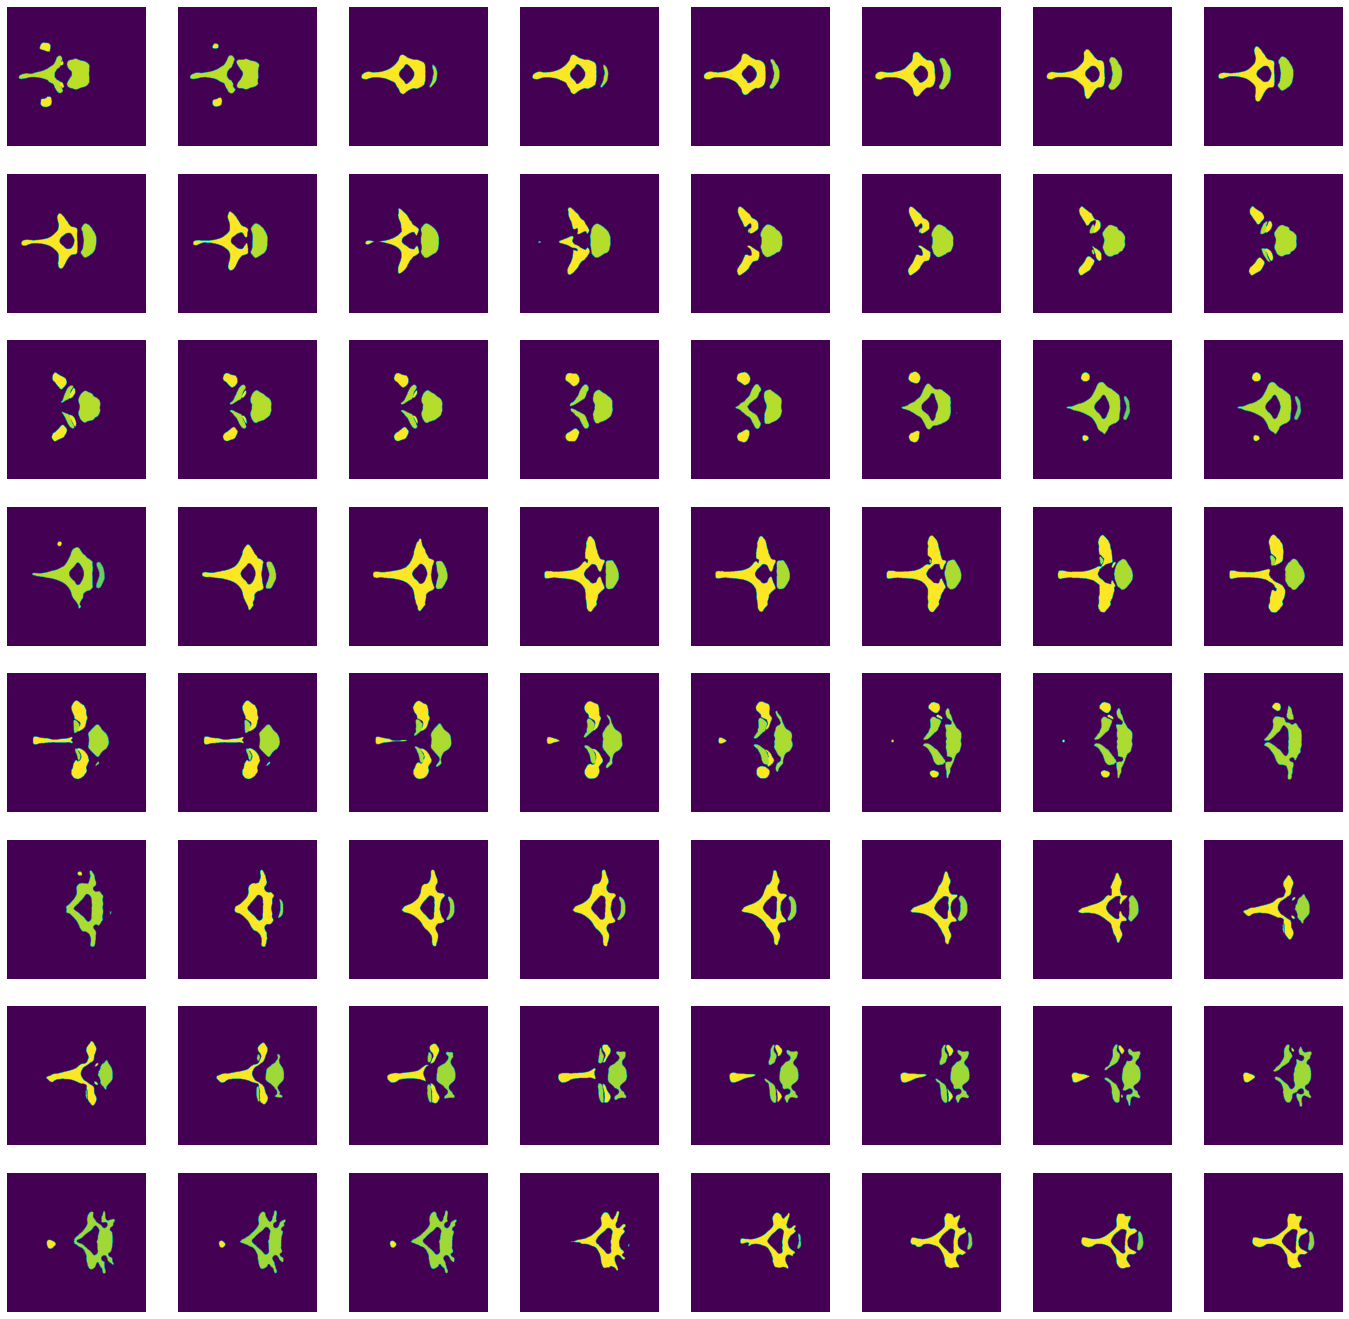

In [5]:
#Segmentation dataの閲覧例
image_path = "./segmentations/1.2.826.0.1.3680043.11988.nii"
nil_img = nib.load(image_path).get_fdata()
print(nil_img.shape) #Z方向に217スライスある

rows = 8 #縦の行
cols = 8 #横の列
axes=[]
plt.figure(figsize=(cols*3, rows*3))

for i in range(rows*cols):
    nib_image = nil_img[:,:,i]
    ax = plt.subplot(rows, cols, i+1)
    plt.imshow(nib_image)
    plt.axis('off')
    plt.imshow(nib_image)

# --> Torch_IOを用いて多色で塗り分け、semantic segmentationを行う

In [ ]:
#Segmentationのある画像を抜き出す

nil_files = [idx.rsplit(".",1)[0] for idx in os.listdir("./segmentations")]
dcm_files = [idx for idx in os.listdir("./train_images")]
#print(nil_files)
#print(dcm_files)
and_list = list(set(nil_files) & set(dcm_files))
print(and_list)

['1.2.826.0.1.3680043.11988', '1.2.826.0.1.3680043.1573', '1.2.826.0.1.3680043.18906', '1.2.826.0.1.3680043.18935', '1.2.826.0.1.3680043.12292', '1.2.826.0.1.3680043.1480', '1.2.826.0.1.3680043.18968', '1.2.826.0.1.3680043.17960', '1.2.826.0.1.3680043.1542', '1.2.826.0.1.3680043.17481', '1.2.826.0.1.3680043.12281', '1.2.826.0.1.3680043.16919', '1.2.826.0.1.3680043.1868', '1.2.826.0.1.3680043.11827', '1.2.826.0.1.3680043.19388', '1.2.826.0.1.3680043.14267', '1.2.826.0.1.3680043.12833', '1.2.826.0.1.3680043.10921', '1.2.826.0.1.3680043.18480', '1.2.826.0.1.3680043.19021', '1.2.826.0.1.3680043.16092', '1.2.826.0.1.3680043.10633', '1.2.826.0.1.3680043.19333', '1.2.826.0.1.3680043.1363', '1.2.826.0.1.3680043.15206']


In [ ]:
class ImgDataset(Dataset):
    def __init__(self, df, max_images = 10):
        self.df = df 
        self.train = 'patient_overall' in df.columns
        self.imgs = []
        self.labels = []
        self.ids = []
        self.prediction_type = []
        for i in range(self.df.shape[0]):
            lst = os.listdir(os.path.join(dirs[1-self.train], self.df.StudyInstanceUID.values[i]))
            random.shuffle(lst)
            for im in lst[:max_images]:
                self.prediction_type.append(["patient_overall", "C1", "C2", "C3", "C4", "C5", "C6", "C7"].index(self.df.prediction_type.values[i]))
                if(not self.train):
                    self.ids.append(self.df.row_id.values[i])
                self.imgs.append(os.path.join(dirs[1-self.train], self.df.StudyInstanceUID.values[i], im))
                if(self.train):
                    self.labels.append(self.df.drop(["StudyInstanceUID"], axis = 1).iloc[i].values)
                else:
                    self.labels.append([0]*8)
            del lst
            gc.collect()
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, index):
        image = load_dicom(self.imgs[index])
        label = self.labels[index]
        gc.collect()
        return image, label, self.ids[index], self.prediction_type[index]

In [ ]:
train_df

In [ ]:
def predict(model, dataloader):
    model.cuda()
    model.eval()
    dataloader = dataloader
    outputs = []
    ids = []
    for item in tqdm(dataloader, leave=False): #tqdm: プログレスバー
        patient_id = item[2][0]
        try:
            images = item[0].cuda().float()
            ids.append(patient_id)
            output = model(images)
            outputs.append(((output.cpu()[0].detach().numpy()).astype(float)[item[3]]))
        except:
            outputs.append(means[item[3]])
    return np.array([min(1,max(i, 0)) for i in outputs]), ids

In [ ]:
model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b4', pretrained=False, num_classes = 8)
batch_size = 1
test_loader = DataLoader(
    ImgDataset(test_df), 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=1
)
criterion = nn.CrossEntropyLoss()

Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip


In [ ]:
pr = predict(model, test_loader)


  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
pr = pd.DataFrame({"row_id" : pr[1], "fractured" : pr[0]}).groupby("row_id").mean()


In [ ]:
submission = pd.read_csv("./sample_submission.csv")
submission.fractured = pr.fractured.to_list()


In [ ]:
submission

#**RSNA EfficientNet (train)**

https://www.kaggle.com/code/rhadleyools/rsna-efficientnet-train

In [ ]:
! pip install pylibjpeg
! pip install python-gdcm
! pip install pylibjpeg-libjpeg
! pip install torchsummary
! pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import re
import gc
import cv2
import copy
import time
import glob
import gdcm
import random
import string
import joblib
import tifffile
import pylibjpeg
import numpy as np 
import pandas as pd 
import torch
from torch import nn
import seaborn as sns
import pydicom as dicom
from torchvision import models
from pydicom import dcmread
import matplotlib.pyplot as plt
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torch.optim import lr_scheduler
import warnings
warnings.filterwarnings("ignore")

#Gdriveをマウント
from google.colab import drive
drive.mount('/content/drive')

os.chdir("/content/drive/MyDrive/Kaggle/rsna-2022-cervical-spine-fracture-detection") #親フォルダ

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
debug = False
train_df = pd.read_csv("./train.csv").head(10 if debug else 100)
test_df = pd.read_csv("./test.csv")
dirs = ["./train_images",  "./test_images"]
train_df
#train_df.describe()

In [ ]:
def load_dicom(path, size = 512):
    img=dicom.dcmread(path)
    img.PhotometricInterpretation = 'YBR_FULL'
    data=img.pixel_array
    data=data-np.min(data)
    if np.max(data) != 0:
        data=data/np.max(data)
    data=(data*255).astype(np.uint8)
    gc.collect()
    return cv2.cvtColor(data.reshape(512,512), cv2.COLOR_GRAY2RGB).transpose(2,0,1)

In [ ]:
class ImgDataset(Dataset):
    def __init__(self, df, max_images = 10):
        self.df = df 
        self.train = 'patient_overall' in df.columns #dfに'patient_overall'の列があるかどうか
        self.imgs = []
        self.labels = []
        for i in range(self.df.shape[0]): #rows
            try: #listのtrain_imageが無かった場合は飛ばす　(※datasetが大きすぎてgdriveに移行しきれていないため)
                lst = os.listdir(os.path.join(dirs[0], self.df.StudyInstanceUID.values[i])) #画像フォルダのパス
                random.shuffle(lst)
                #for im in lst[:max_images]:
                for im in lst:
                    self.imgs.append(os.path.join(dirs[0], self.df.StudyInstanceUID.values[i], im)) #train_images内の画像毎のパス
                    if(self.train):
                        self.labels.append(self.df.drop(["StudyInstanceUID"], axis = 1).iloc[i].values) #ラベルをdfからリスト化
                    else:
                        self.labels.append(None)
                del lst
            except: pass
            gc.collect()
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, index):
        image = load_dicom(self.imgs[index])
        label = self.labels[index]
        gc.collect()
        return image, label

In [ ]:

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

# image_file = sorted(glob.glob("./train_images/1.2.826.0.1.3680043.10001/*.dcm"), key=natural_keys) #数字順に並び替え
# print(f"image_num = {len(image_file)}")
# plt.figure(figsize=(20, 20))


imgs, labels=[],[]
train = 'patient_overall' in train_df.columns

for i in range(train_df.shape[0]): #rows
        try: #listのtrain_imageが無かった場合は飛ばす　(※datasetが大きすぎてgdriveに移行しきれていないため)
            lst = sorted(os.listdir(os.path.join(dirs[0], train_df.StudyInstanceUID.values[i])), key=natural_keys) #画像フォルダのパス
            #random.shuffle(lst)
            print(lst)
            #for im in lst[:max_images]:
            for im in lst:
                imgs.append(os.path.join(dirs[0], train_df.StudyInstanceUID.values[i], im)) #train_images内の画像毎のパス
                if(train):
                    labels.append(train_df.drop(["StudyInstanceUID"], axis = 1).iloc[i].values) #ラベルをdfからリスト化
                else:
                    labels.append(None)
            del lst
        except: pass
print(imgs)
print(labels)

In [ ]:
labels

In [ ]:
train_df

In [ ]:
d = ImgDataset(train_df)
d.__getitem__(0)[0].shape


(3, 512, 512)

In [ ]:
with open("/content/best_score.txt", "w") as f:
    f.write("100000")

In [ ]:
def train_model(model, dataloaders_dict, criterion, optimizer, num_epochs):
    with open("/content/best_score.txt", "r") as f:
        best_loss = float(f.read())

    for epoch in range(num_epochs):
        model.cuda()
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            epoch_loss = 0.0
            epoch_acc = 0
            
            dataloader = dataloaders_dict[phase]
            for item in tqdm(dataloader, leave=False):
                images = item[0].cuda().float()
                classes = item[1].cuda().float()
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    output = model(images)
                    loss = criterion(output, classes)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    epoch_loss += loss.item() * len(output)
                    epoch_acc += torch.sum((output>0.5) == classes.data)/8
                    gc.collect()

            data_size = len(dataloader.dataset)
            epoch_loss = epoch_loss / data_size
            epoch_acc = epoch_acc.double() / data_size

            print(f'Epoch {epoch + 1}/{num_epochs} | {phase:^5} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}')
        
        if epoch_loss < best_loss:
            traced = torch.jit.trace(model, torch.zeros(1, 3, 512, 512).cuda())
            traced.save('model.pth')
            best_loss = epoch_loss
            with open("best_score.txt", "w") as f:
                f.write(str(best_loss))

In [ ]:
model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b4', pretrained=False, num_classes = 8)
train, val = train_test_split(train_df, test_size=0.2, random_state=42)
batch_size = 1
train_loader = DataLoader(
    ImgDataset(train), 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=1
)
val_loader = DataLoader(
    ImgDataset(val), 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=1
)
dataloaders_dict = {"train": train_loader, "val": val_loader}
criterion = nn.MSELoss()

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=4)
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
# train_model(model, dataloaders_dict, criterion, optimizer, 2)
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
# train_model(model, dataloaders_dict, criterion, optimizer, 2)

  0%|          | 0/7559 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

#**Extracting segmentation**

https://www.kaggle.com/code/samuelcortinhas/extracting-vertebrae-c1-c7

In [2]:
!pip install path
!pip install pydicom
import os
import cv2
import glob
import traceback
import cv2 as cv
import numpy as np
import pandas as pd
from path import Path
from tqdm import tqdm
import nibabel as nib
import pydicom as dicom
import tensorflow as tf
from keras import layers
from pydicom import dcmread
from tensorflow import keras
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from pydicom.data import get_testdata_files
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
from pydicom.pixel_data_handlers.util import apply_voi_lut
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import os
import gc
import cv2
import copy
import time
import math
import random
import string
import joblib
import tifffile
import numpy as np 
import pandas as pd 
import torch
from torch import nn
import seaborn as sns
import pydicom as dicom
from torchvision import models
from scipy.special import expit
from pydicom import dcmread
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torch.optim import lr_scheduler
import warnings
warnings.filterwarnings("ignore")

#Gdriveをマウント
from google.colab import drive
drive.mount('/content/drive')

os.chdir("/content/drive/MyDrive/Kaggle/rsna-2022-cervical-spine-fracture-detection") #親フォルダ

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 5.1 MB/s 
Mounted at /content/drive


In [5]:
bad = np.array([['1.2.826.0.1.3680043.10197_C1', '1.2.826.0.1.3680043.10197','C1'],['1.2.826.0.1.3680043.10454_C1', '1.2.826.0.1.3680043.10454','C1'],['1.2.826.0.1.3680043.10690_C1', '1.2.826.0.1.3680043.10690','C1']], dtype=np.object)

# Load dataframes
train_df = pd.read_csv("/content/drive/MyDrive/Kaggle/rsna-2022-cervical-spine-fracture-detection/train.csv")
train_bbox = pd.read_csv("/content/drive/MyDrive/Kaggle/rsna-2022-cervical-spine-fracture-detection/train_bounding_boxes.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Kaggle/rsna-2022-cervical-spine-fracture-detection/test.csv")
ss = pd.read_csv("/content/drive/MyDrive/Kaggle/rsna-2022-cervical-spine-fracture-detection/sample_submission.csv")

# Print dataframe shapes
print('train shape:', train_df.shape)
print('train bbox shape:', train_bbox.shape)
print('test shape:', test_df.shape)
print('ss shape:', ss.shape)
print('')

# Show first few entries
train_df.head(3)
train_bbox.head(3)

train shape: (2019, 9)
train bbox shape: (7217, 6)
test shape: (3, 3)
ss shape: (3, 2)



,StudyInstanceUID,x,y,width,height,slice_number
0,1.2.826.0.1.3680043.10051,219.27715,216.71419,17.30440,20.38517,133
1,1.2.826.0.1.3680043.10051,221.56460,216.71419,17.87844,25.24362,134
2,1.2.826.0.1.3680043.10051,216.82151,221.62546,27.00959,26.37454,135


### create segmentation

In [6]:
# Store segmentation paths in a dataframe
base_path = "/content/drive/MyDrive/Kaggle/rsna-2022-cervical-spine-fracture-detection"
seg_paths = glob.glob(f"{base_path}/segmentations/*")
seg_df = pd.DataFrame({'path': seg_paths})
seg_df['StudyInstanceUID'] = seg_df['path'].apply(lambda x:x.split('/')[-1][:-4]) #pathを整形してStudyInstanceUIDを作成
seg_df = seg_df[['StudyInstanceUID','path']]
print('seg_df shape:', seg_df.shape)
seg_df.head(3)

seg_df shape: (87, 2)


,StudyInstanceUID,path
0,1.2.826.0.1.3680043.10633,/content/drive/MyDrive/Kaggle/rsna-2022-cervic...
1,1.2.826.0.1.3680043.10921,/content/drive/MyDrive/Kaggle/rsna-2022-cervic...
2,1.2.826.0.1.3680043.11827,/content/drive/MyDrive/Kaggle/rsna-2022-cervic...


In [9]:
#Segmentationのある画像を抜き出す

nil_files = [idx.rsplit(".",1)[0] for idx in os.listdir("/content/drive/MyDrive/Kaggle/rsna-2022-cervical-spine-fracture-detection/segmentations")]
dcm_files = [idx for idx in os.listdir("/content/drive/MyDrive/Kaggle/rsna-2022-cervical-spine-fracture-detection/train_images")]
#print(nil_files)
#print(dcm_files)
and_list = list(set(nil_files) & set(dcm_files))
print(and_list)

['1.2.826.0.1.3680043.10921', '1.2.826.0.1.3680043.16919', '1.2.826.0.1.3680043.12292', '1.2.826.0.1.3680043.1363', '1.2.826.0.1.3680043.1542', '1.2.826.0.1.3680043.19333', '1.2.826.0.1.3680043.17481', '1.2.826.0.1.3680043.1480', '1.2.826.0.1.3680043.12281', '1.2.826.0.1.3680043.14267', '1.2.826.0.1.3680043.18906', '1.2.826.0.1.3680043.15206', '1.2.826.0.1.3680043.19388', '1.2.826.0.1.3680043.12833', '1.2.826.0.1.3680043.18480', '1.2.826.0.1.3680043.16092', '1.2.826.0.1.3680043.1868', '1.2.826.0.1.3680043.11988', '1.2.826.0.1.3680043.10633', '1.2.826.0.1.3680043.18935', '1.2.826.0.1.3680043.1573', '1.2.826.0.1.3680043.17960', '1.2.826.0.1.3680043.19021', '1.2.826.0.1.3680043.18968', '1.2.826.0.1.3680043.11827']
